In [1]:
import uproot
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import roc_curve, auc

In [2]:
# Obtaining data
g_data = uproot.open('/project/rpp-blairt2k/machine_learning/data/HKHybrid/fiTQun/HKHybrid_gamma_3000x400_w_mPMT.fiTQun.root')['fiTQun']
e_data = uproot.open('/project/rpp-blairt2k/machine_learning/data/HKHybrid/fiTQun/HKHybrid_e-_3000x400_wo_mPMT.fiTQun.root')['fiTQun']
mu_data = uproot.open('/project/rpp-blairt2k/machine_learning/data/HKHybrid/fiTQun/HKHybrid_mu-_3000x400_wo_mPMT.fiTQun.root')['fiTQun']
pi0_data = uproot.open('/project/rpp-blairt2k/machine_learning/data/HKHybrid/fiTQun/HKHybrid_pi0_3000x400_wo_mPMT.fiTQun.root')['fiTQun']

In [6]:
# Obtain cuts on fiducial volume
fv_2m_emu = np.load("/project/rpp-blairt2k/machine_learning/data/HKHybrid/numpy/e-mu-_wo_mpmts_fv_4m.npy", allow_pickle="TRUE").item()
fv_2m_epi0 = np.load("/project/rpp-blairt2k/machine_learning/data/HKHybrid/numpy/e-pi0_wo_mpmts_fv_4m.npy", allow_pickle="TRUE").item()
fv_2m_eg = np.load("/project/rpp-blairt2k/machine_learning/data/HKHybrid/numpy/e-g_w_mpmts_fv_2m.npy", allow_pickle="TRUE").item()
fv_2m_emu['mu-'] = fv_2m_emu['mu-'] - 1200000
fv_2m_epi0['pi0'] = fv_2m_epi0['pi0'] - 1200000
fv_2m_eg['gamma'] = fv_2m_eg['gamma']

In [21]:
fv_2m_eg, fv_2m_emu, fv_2m_epi0

({'e-': array([     0,      2,      3, ..., 599997, 599998, 599999]),
  'pi0': array([ 600002,  600003,  600004, ..., 1199996, 1199997, 1199998])},
 {'e-': array([      2,       3,       7, ..., 1199997, 1199998, 1199999]),
  'mu-': array([      1,       2,       7, ..., 1199997, 1199998, 1199999])},
 {'e-': array([      2,       3,       7, ..., 1199997, 1199998, 1199999]),
  'pi0': array([      1,       4,       5, ..., 1199996, 1199997, 1199998])})

In [3]:

# Structure within a fitqun output file
print(e_data.show())

name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
cluster_ncand        | int32_t                  | AsDtype('>i4')
cluster_tstart       | float[]                  | AsJagged(AsDtype('>f4'))
cluster_tend         | float[]                  | AsJagged(AsDtype('>f4'))
cluster_nhits        | int32_t[]                | AsJagged(AsDtype('>i4'))
cluster_totq         | float[]                  | AsJagged(AsDtype('>f4'))
cluster_goodflag     | int32_t[]                | AsJagged(AsDtype('>i4'))
cluster_npeaks       | int32_t[][6]             | AsJagged(AsDtype("('>i4', (...
cluster_ipeak        | int32_t[][6][10]         | AsJagged(AsDtype("('>i4', (...
cluster_timeofpeak   | float[][6][10]           | AsJagged(AsDtype("('>f4', (...
muechk_ncand         | int32_t[6]               | AsDtype("('>i4', (6,))")
muechk_toya          | float[6]                 | AsDtype("('>f4', (6,))")
muech

In [17]:
np.where(e_data['fq1rpcflg'].array()[:,0,1]==1)

(<Array [19, 23, 46, ... 1199943, 1199966] type='35569 * int64'>,)

In [20]:
# get indices of test events
# idxs_path = '/project/rpp-blairt2k/machine_learning/data/HKHybrid/numpy/e-pi0_w_mpmts_idxs_541tts.npz'
idxs_path = '/project/rpp-blairt2k/machine_learning/data/HKHybrid/numpy/HKHybrid_e-gamma_E0to1000MeV_unif-pos-R3240-y3287cm_4pi-dir_idxs_w_mPMT.npz'
idxs = np.load(idxs_path, allow_pickle=True)
test_idxs = idxs['test_idxs']

In [21]:
# open h5 file and get data for test events
# data_path = "/project/rpp-blairt2k/machine_learning/data/HKHybrid/numpy/e-mu-pi0.hdf5"
data_path = "/project/rpp-blairt2k/machine_learning/data/HKHybrid/numpy/HKHybrid_e-gamma_E0to1000MeV_unif-pos-R3240-y3287cm_4pi-dir_6Mevts_w_mPMT.hdf5"
h5_file = h5py.File(data_path, "r")
h5_positions  = np.array(h5_file['positions'])[test_idxs].squeeze()
h5_labels     = np.array(h5_file['labels'])[test_idxs].squeeze()

In [22]:
# loc = '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2021-12-28/15-23-12/outputs' # e/mu w/o mpmt
# loc = '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2022-12-14/10-18-56/outputs' # e/mu w/ mpmt/ w/ PMT flag
# loc = '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2021-12-30/17-40-40/outputs' # e/pi0 w/ mpmt/ w/ PMT flag
loc = '/project/rpp-blairt2k/jgao/WatChMaL/outputs/2023-03-03/08-32-31/outputs' # gamma w/ pmt
HKHybrid_softmax   = np.load(loc + "/softmax.npy")
HKHybrid_labels    = np.load(loc + "/labels.npy")
HKHybrid_indices   = np.load(loc + "/indices.npy")

In [23]:
# match up indices from output to indices in test_idxs
intersection = np.intersect1d(HKHybrid_indices, test_idxs, return_indices=True)
HKHybrid_softmax[intersection[2]] = np.copy(HKHybrid_softmax)[intersection[1]]
HKHybrid_labels[intersection[2]] = np.copy(HKHybrid_labels)[intersection[1]]

# e/mu separation


## Extracting 1 ring NLL data

In [7]:
# The first nLL value is for electron hypothesis and second nLL is for the muon hypothesis
e_nll_1 = np.array(e_data['fq1rnll'].array()[:,0,1])#[fv_2m_emu['e-']])
e_nll_2 = np.array(e_data['fq1rnll'].array()[:,0,2])#[fv_2m_emu['e-']])
mu_nll_1 = np.array(mu_data['fq1rnll'].array()[:,0,1])#[fv_2m_emu['mu-']])
mu_nll_2 = np.array(mu_data['fq1rnll'].array()[:,0,2])#[fv_2m_emu['mu-']])

# The following is to cut away the bad pos reconstruction events
e_recon_pos_e = np.array(e_data['fq1rpos'].array()[:,0,1,:])
mu_recon_pos_mu = np.array(mu_data['fq1rpos'].array()[:,0,2,:])
fq_bad_e_events = np.where((e_recon_pos_e[:,0] < -5000) | (e_recon_pos_e[:,0] > 5000) |
                           (e_recon_pos_e[:,1] < -5000) | (e_recon_pos_e[:,1] > 5000) |
                           (e_recon_pos_e[:,2] < -5000) | (e_recon_pos_e[:,2] > 5000))[0]
fq_bad_mu_events = np.where((mu_recon_pos_mu[:,0] < -5000) | (mu_recon_pos_mu[:,0] > 5000) |
                            (mu_recon_pos_mu[:,1] < -5000) | (mu_recon_pos_mu[:,1] > 5000) |
                            (mu_recon_pos_mu[:,2] < -5000) | (mu_recon_pos_mu[:,2] > 5000))[0]

In [12]:
good_events_e = np.delete(range(len(e_recon_pos_e)), fq_bad_e_events)
good_events_mu = np.delete(range(len(mu_recon_pos_mu)), fq_bad_mu_events)

e_nll_1 = e_nll_1[good_events_e]
e_nll_2 = e_nll_2[good_events_e]
mu_nll_1 = mu_nll_1[good_events_mu]
mu_nll_2 = mu_nll_2[good_events_mu]

In [54]:
# len(np.where(HKHybrid_labels == 2 )[0])
len(intersection[1]), len(intersection[2])

(1170000, 1170000)

### Histogram checking

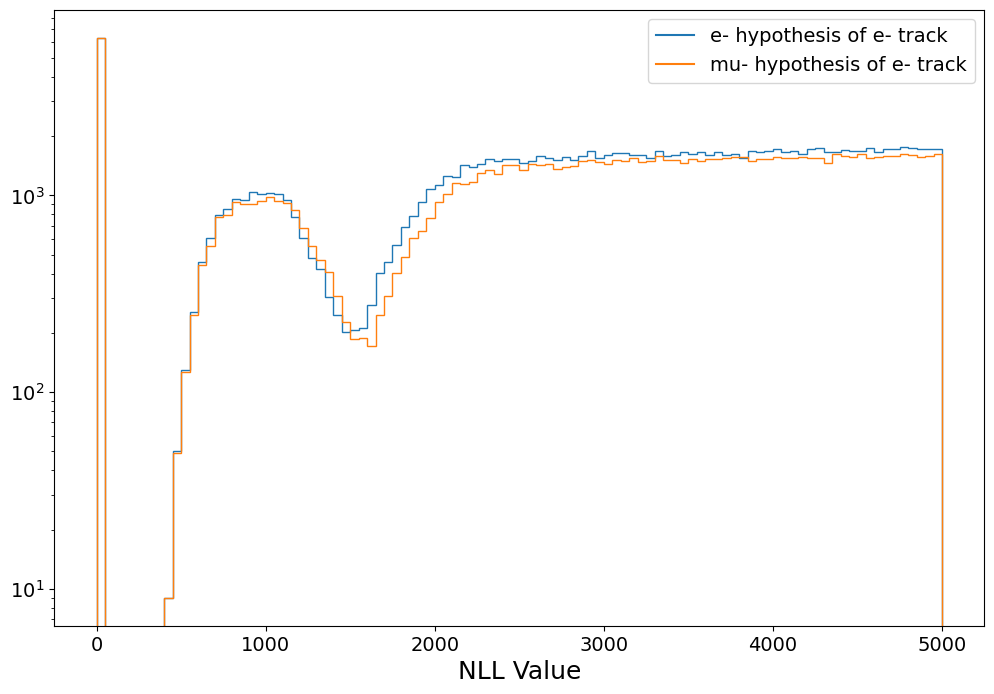

In [7]:
# Plotting histogram to check data
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(e_nll_1, bins=100, range=[0., 5000.], label='e- hypothesis of e- track', histtype='step', log=True)
ax.hist(e_nll_2, bins=100, range=[0., 5000.], label='mu- hypothesis of e- track', histtype='step', log=True)

# Create new legend handles but use the colors from the existing ones
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

plt.legend(handles=new_handles, labels=labels, fontsize=14)
plt.xlabel('NLL Value', fontsize=18)
plt.xticks(fontsize=14)  # changing x-axis lable size
plt.yticks(fontsize=14)
# plt.title('NLL Values of $e^-$ & $\mu^-$ Hypothesis for $e^-$', fontsize=18)
plt.show()

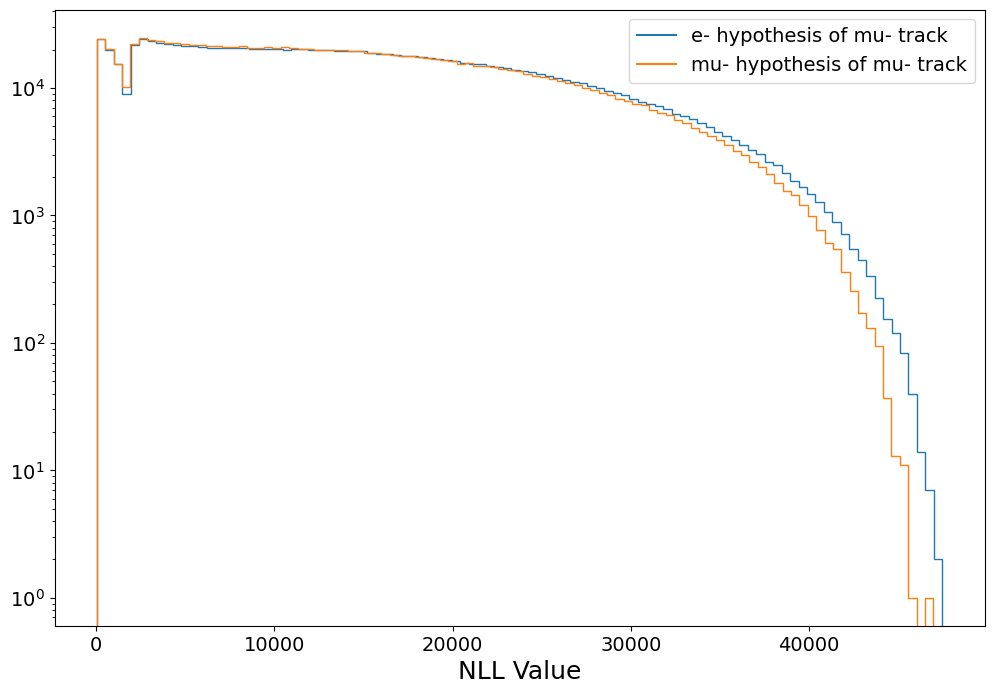

In [8]:
# Plotting mu histogram to check data
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(mu_nll_1, bins=100, label='e- hypothesis of mu- track', histtype='step', log=True)
ax.hist(mu_nll_2, bins=100, label='mu- hypothesis of mu- track', histtype='step', log=True)

# Create new legend handles but use the colors from the existing ones
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

plt.legend(handles=new_handles, labels=labels, fontsize=14)
plt.xlabel('NLL Value', fontsize=18)
plt.xticks(fontsize=14)  # changing x-axis lable size
plt.yticks(fontsize=14)
# plt.title('NLL Values of $e^-$ & $\mu^-$ Hypothesis for $\mu^-$', fontsize=18)
plt.show()

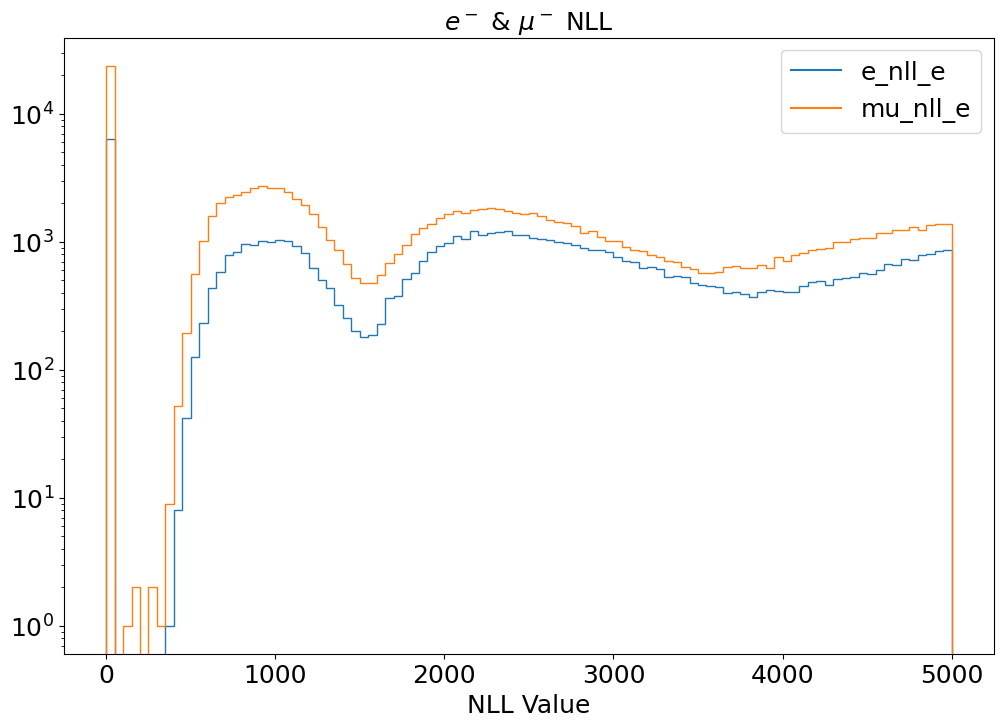

In [8]:
# Plotting e and mu histograms together
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(e_nll_1, bins=100, range=[0., 5000.], label='e- hypothesis of e- track', histtype='step', log=True)
ax.hist(mu_nll_1, bins=100, range=[0., 5000.], label='e- hypothesis of mu- track', histtype='step', log=True)

# Create new legend handles but use the colors from the existing ones
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

plt.legend(handles=new_handles, labels=labels, fontsize=18)
plt.xlabel('NLL Value', fontsize=18)
plt.xticks(fontsize=18)  # changing x-axis lable size
plt.yticks(fontsize=18)
plt.title('$e^-$ & $\mu^-$ NLL', fontsize=18)
plt.show()

# Processing NLL for e and mu

In [9]:
e_nll_diff_e = e_nll_1 - e_nll_2  # Small number = e; big number = mu
e_nll_diff_mu = e_nll_2 - e_nll_1  # Small number = mu; big number = e

mu_nll_diff_e = mu_nll_1 - mu_nll_2  # Small number = e, big number = mu
mu_nll_diff_mu = mu_nll_2 - mu_nll_1  # Small number = mu, big number = e

### Histogram checking

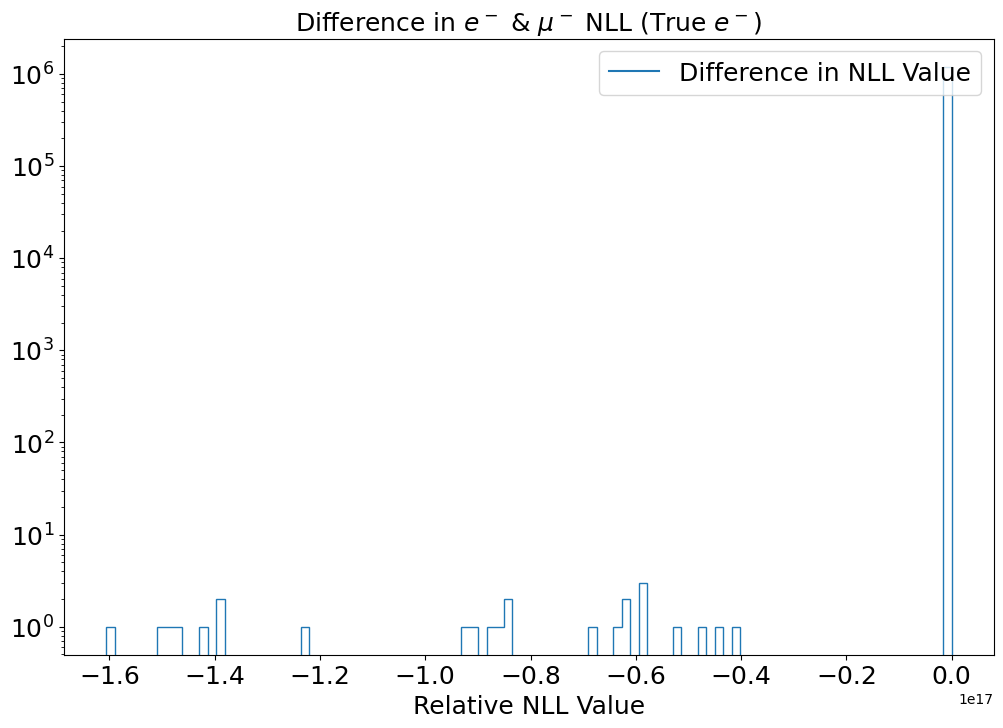

In [11]:
# Plotting the difference in e and mu NLL value
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(e_nll_diff_e, bins=100, label='Difference in NLL Value', histtype='step', log=True)

# Create new legend handles but use the colors from the existing ones
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

plt.legend(handles=new_handles, labels=labels, fontsize=18)
plt.xlabel('Relative NLL Value', fontsize=18)
plt.xticks(fontsize=18)  # changing x-axis lable size
plt.yticks(fontsize=18)
plt.title('Difference in $e^-$ & $\mu^-$ NLL (True $e^-$)', fontsize=18)
plt.show()

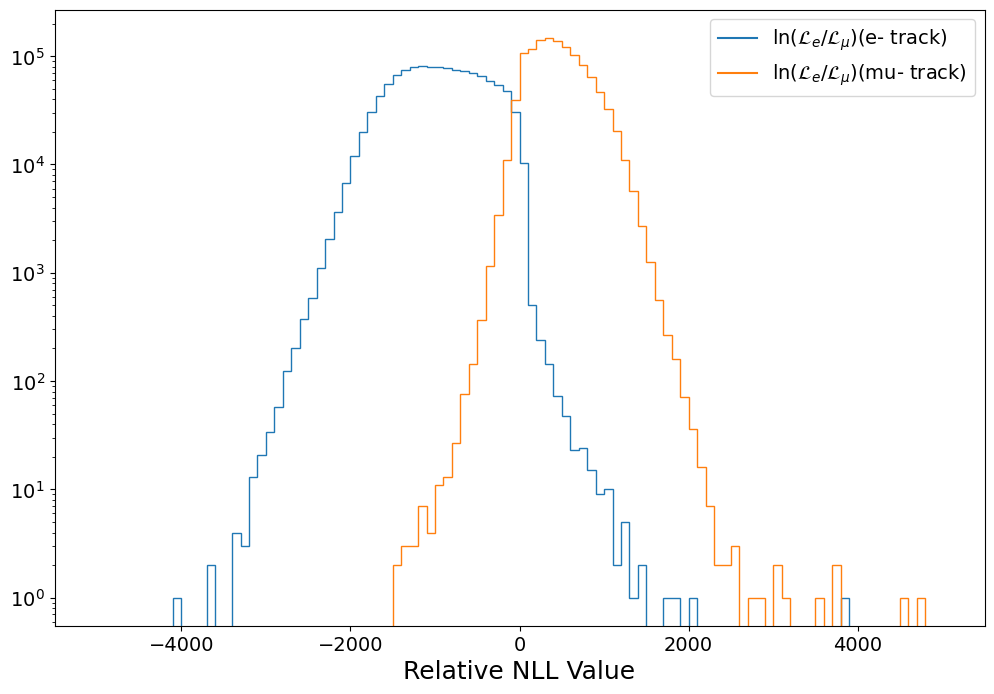

In [13]:
# Plotting the difference in e and mu NLL value
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(e_nll_diff_e, range=[-5000., 5000.], bins=100, label=r'ln($\mathcal{L}_e/\mathcal{L}_\mu$)(true e- track)', histtype='step', log=True)
ax.hist(mu_nll_diff_e, range=[-5000., 5000.], bins=100, label=r'ln($\mathcal{L}_e/\mathcal{L}_\mu$)(true mu- track)', histtype='step', log=True)

# Create new legend handles but use the colors from the existing ones
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

plt.legend(handles=new_handles, labels=labels, fontsize=14)
plt.xlabel('Relative NLL Value', fontsize=18)
plt.xticks(fontsize=14)  # changing x-axis lable size
plt.yticks(fontsize=14)
# plt.title('Difference in $e^-$ & $\mu^-$ NLL', fontsize=18)
plt.show()

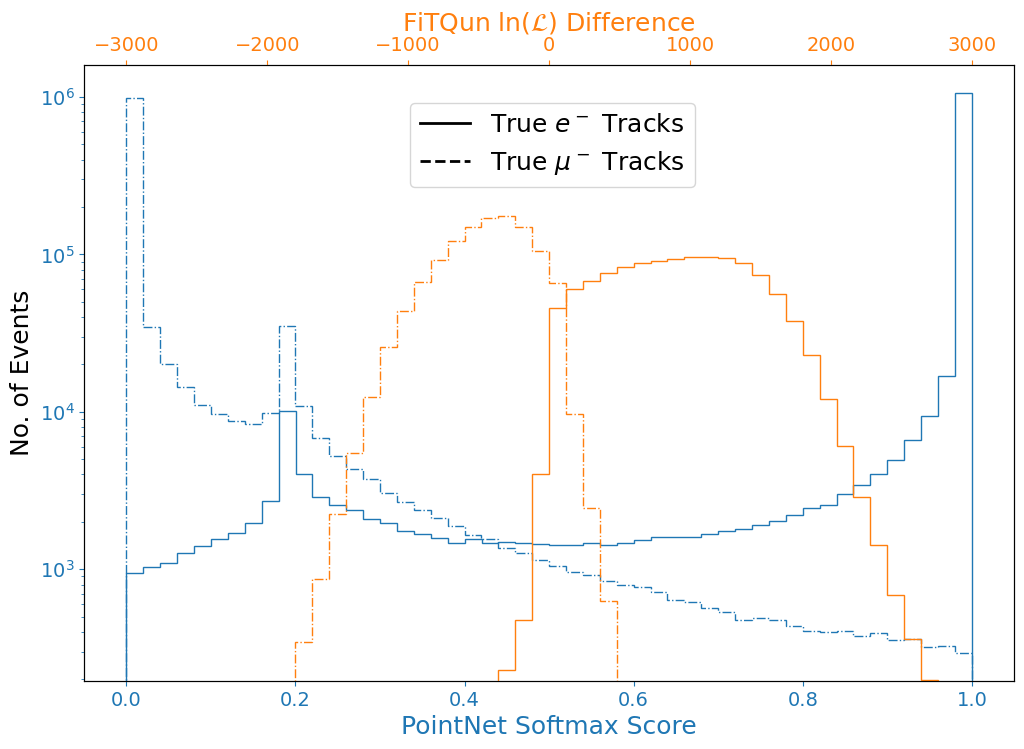

In [11]:
e_classified_as_e  = HKHybrid_softmax[HKHybrid_labels == 1][:, 1]
mu_classified_as_e = HKHybrid_softmax[HKHybrid_labels == 2][:, 1]
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twiny()

# Plotting histograms for ax1
ax1.hist(e_classified_as_e, bins=50, histtype='step', color='C0',# label='1', 
         linestyle='-', log=True)
ax1.hist(mu_classified_as_e, bins=50, histtype='step', color='C0',# label='2', 
         linestyle='-.',log=True)
ax1.set_xlabel('PointNet Softmax Score', color='C0', fontsize=18)
ax1.set_ylabel('No. of Events', fontsize=18)
ax1.tick_params(which='both', colors='C0', labelsize=14)

# Plotting histograms for ax2
ax2.hist(-e_nll_diff_e, bins=50, color='C1', # label=r'ln($\mathcal{L}_e/\mathcal{L}_\mu$)(true e- track)', 
         range=[-3000,3000], histtype='step', linestyle='-', log=True)
ax2.hist(-mu_nll_diff_e, bins=50, color='C1',# label=r'ln($\mathcal{L}_e/\mathcal{L}_\mu$)(true mu- track)', 
         range=[-3000,3000], histtype='step', linestyle='-.', log=True)
ax2.set_xlabel('FiTQun ln($\mathcal{L}$) Difference', color='C1', fontsize=18)
ax2.tick_params(which='both', colors='C1', labelsize=14)

# Setting legends
# Creating a global legend with black lines
legend_line_solid = plt.Line2D([0], [0], color='black', linestyle='-', linewidth=2)
legend_line_dashed = plt.Line2D([0], [0], color='black', linestyle='--', linewidth=2)
plt.figlegend([legend_line_solid, legend_line_dashed], ['True $e^-$ Tracks', 'True $\mu^-$ Tracks'], fontsize=18, loc=(0.4,0.75))

# Display plot
plt.savefig('../pointnet/plots/e-mu-_classification/softmax_n_fqNll.png')

# e/pi0 separation

### Pi0 NLL and reconstructed Pi0 mass

In [16]:
e_pi0nll = np.array(e_data['fqpi0nll'].array()[:,0])#[fv_2m_epi0['e-']])
pi0_pi0nll = np.array(pi0_data['fqpi0nll'].array()[:, 0])#[fv_2m_epi0['pi0']])
pi0_1rnll_e  = np.array(pi0_data['fq1rnll'].array()[:,0,1])#[fv_2m_epi0['pi0']])
pi0_mass =  np.array(pi0_data['fqpi0mass'].array()[:,0])

In [17]:
e_as_e_from_pi0nll = e_nll_1 - e_pi0nll          # small number = e-; big number = pi0
pi0_as_e_from_pi0nll = pi0_1rnll_e - pi0_pi0nll  # small number = e-; big number = pi0
# pi0_as_e_from_pi0nll = pi0_pi0nll - pi0_1rnll_e  # small number = pi0; big number = e-

In [51]:
# The following is to cut away the bad pos reconstruction events
e_recon_pos_e = np.array(e_data['fq1rpos'].array()[:,0,1,:])
mu_recon_pos_mu = np.array(mu_data['fq1rpos'].array()[:,0,2,:])
fq_bad_e_events = np.where((e_recon_pos_e[:,0] < -5000) | (e_recon_pos_e[:,0] > 5000) |
                           (e_recon_pos_e[:,1] < -5000) | (e_recon_pos_e[:,1] > 5000) |
                           (e_recon_pos_e[:,2] < -5000) | (e_recon_pos_e[:,2] > 5000))[0]
fq_bad_mu_events = np.where((mu_recon_pos_mu[:,0] < -5000) | (mu_recon_pos_mu[:,0] > 5000) |
                            (mu_recon_pos_mu[:,1] < -5000) | (mu_recon_pos_mu[:,1] > 5000) |
                            (mu_recon_pos_mu[:,2] < -5000) | (mu_recon_pos_mu[:,2] > 5000))[0]

(1198485, 1198930)

In [48]:
mass_idx = np.where(pi0_mass < 1000.)[0]
score_idx = np.where(pi0_as_e_from_pi0nll < 100.)[0]

In [55]:
fig = plt.figure(figsize=(12,8))
ax.hist2d(pi0_mass[mass_idx], pi0_as_e_from_pi0nll[mass_idx])

# Plot dwall vs. towall as histo and overlay energy resolution (%)
nll_edges = np.linspace(0., 400., 20.)
pi0mass_edges = np.linspace(0., 250., 12.5)

residuals_ml = abs(((good_ml_recon_energies/good_true_energies) - 1)*100)
residuals_fq = abs(((good_fq_recon_energies/good_true_energies) - 1)*100)

energy_res_bin_ml = np.zeros((len(towall_edges)-1, len(dwall_edges)-1))
energy_res_bin_fq = np.zeros((len(towall_edges)-1, len(dwall_edges)-1))


# Fill the array with average energy resolutions
for i in range(len(towall_edges)-1):
    for j in range(len(dwall_edges)-1):
        # Get indices of events in the current bin
        indices = np.where((towall >= towall_edges[i]) & (towall < towall_edges[i+1]) &
                           (dwall >= dwall_edges[j]) & (dwall < dwall_edges[j+1]))

        # Calculate average energy resolution for the bin
        if len(indices[0]) > 0:
            energy_res_bin_ml[i, j] = np.mean(np.take(residuals_ml, indices))
            energy_res_bin_fq[i, j] = np.mean(np.take(residuals_fq, indices))

masked_energy_res_bin_ml = np.ma.masked_where(energy_res_bin_ml == 0, energy_res_bin_ml)
masked_energy_res_bin_fq = np.ma.masked_where(energy_res_bin_fq == 0, energy_res_bin_fq)

# Keep the colour consistent
global_min = min(np.min(energy_res_bin_ml), np.min(energy_res_bin_fq))
global_max = max(np.max(energy_res_bin_ml), np.max(energy_res_bin_fq))

# Create a colormap that sets masked values (zeros) to white
cmap = plt.cm.Reds  # or any colormap you prefer
cmap.set_bad(color='white')

fig, ax = plt.subplots( figsize=(20, 7))
# Plot for ML residuals
pc = axs[0].pcolormesh(towall_edges, dwall_edges, masked_energy_res_bin_ml.T, cmap=cmap, shading='auto', 
                       vmin=global_min, vmax=global_max)
ax.set_xlabel('Towall Distance', fontsize=18)
ax.set_ylabel('Dwall Distance', fontsize=18)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
# axs[0].set_title('PointNet Residuals', fontsize=18)


# Colorbar
cbar = fig.colorbar(pc, ax=ax.ravel().tolist())
cbar.set_label(label='Average Energy Resolution (%)', fontsize=18)

# plt.savefig(f'plots/{particle_names[0]}_EResolution_68percentile/{particle_names[0]}_EResolution_68percentile_FV_compare_261MeVorMore.png')
plt.show()

<Figure size 1200x800 with 0 Axes>

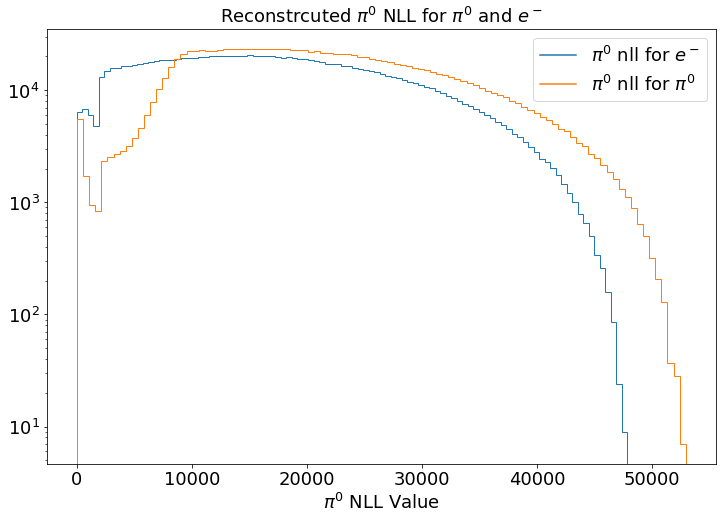

In [35]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(e_pi0nll, bins=100, label='$\pi^0$ nll for $e^-$', histtype='step', log=True)
ax.hist(pi0_pi0nll, bins=100, label='$\pi^0$ nll for $\pi^0$', histtype='step', log=True)

# Create new legend handles but use the colors from the existing ones
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

plt.legend(handles=new_handles, labels=labels, fontsize=18)
plt.xlabel('$\pi^0$ NLL Value', fontsize=18)
plt.xticks(fontsize=18)  # changing x-axis lable size
plt.yticks(fontsize=18)
plt.title('Reconstrcuted $\pi^0$ NLL for $\pi^0$ and $e^-$', fontsize=18)
plt.show()

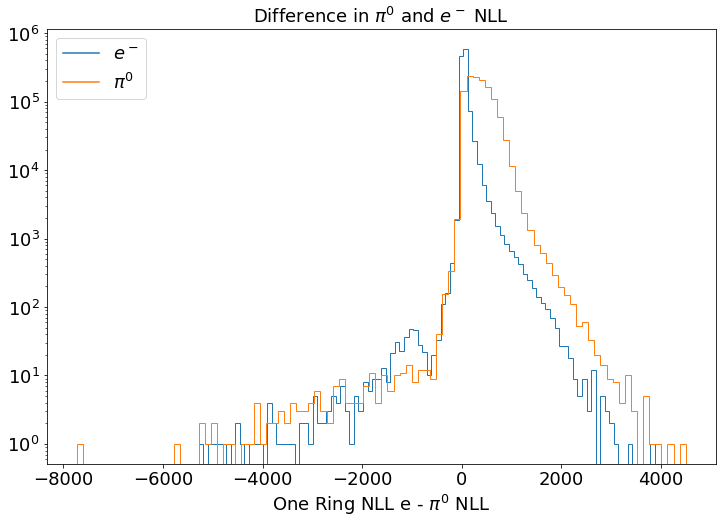

In [36]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(e_as_e_from_pi0nll, bins=100, label='$e^-$', histtype='step', log=True)
ax.hist(pi0_as_e_from_pi0nll, bins=100, label='$\pi^0$', histtype='step', log=True)

# Create new legend handles but use the colors from the existing ones
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

plt.legend(handles=new_handles, labels=labels, fontsize=18)
plt.xlabel('One Ring NLL e - $\pi^0$ NLL', fontsize=18)
plt.xticks(fontsize=18)  # changing x-axis lable size
plt.yticks(fontsize=18)
plt.title('Difference in $\pi^0$ and $e^-$ NLL', fontsize=18)
plt.show()

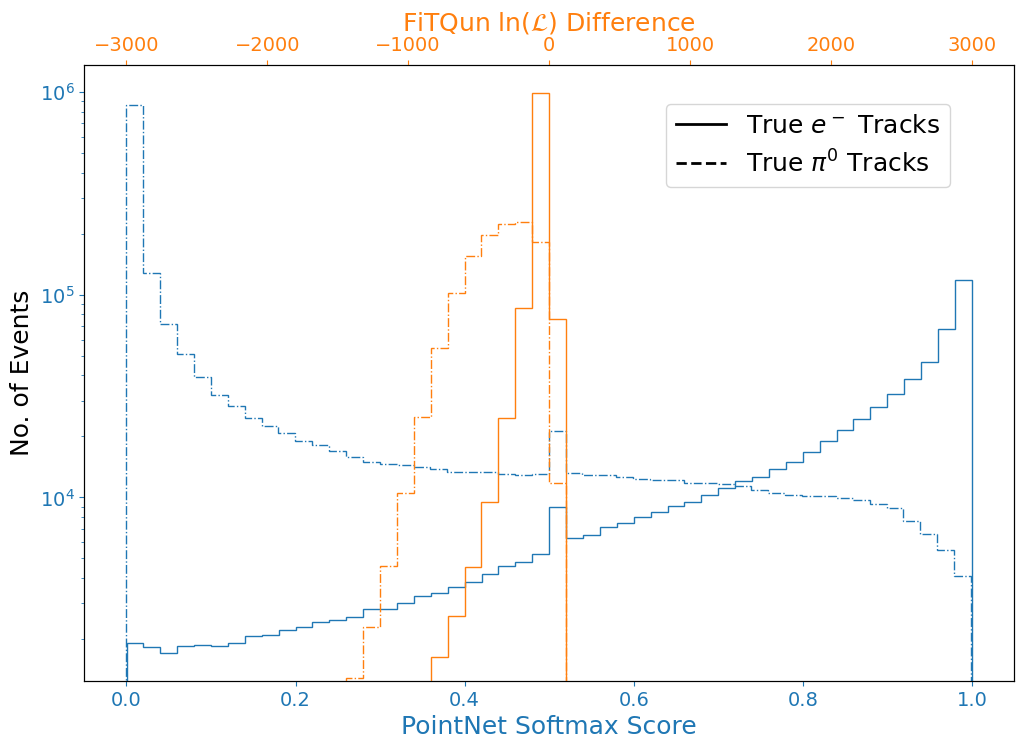

In [19]:
e_classified_as_e  = HKHybrid_softmax[HKHybrid_labels == 1][:, 1]
pi0_classified_as_e = HKHybrid_softmax[HKHybrid_labels == 3][:, 1]
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twiny()

# Plotting histograms for ax1
ax1.hist(e_classified_as_e, bins=50, histtype='step', color='C0',# label='1', 
         linestyle='-', log=True)
ax1.hist(pi0_classified_as_e, bins=50, histtype='step', color='C0',# label='2', 
         linestyle='-.',log=True)
ax1.set_xlabel('PointNet Softmax Score', color='C0', fontsize=18)
ax1.set_ylabel('No. of Events', fontsize=18)
ax1.tick_params(which='both', colors='C0', labelsize=14)

# Plotting histograms for ax2
ax2.hist(-e_as_e_from_pi0nll, bins=50, color='C1', # label=r'ln($\mathcal{L}_e/\mathcal{L}_\mu$)(true e- track)', 
         range=[-3000,3000], histtype='step', linestyle='-', log=True)
ax2.hist(-pi0_as_e_from_pi0nll, bins=50, color='C1',# label=r'ln($\mathcal{L}_e/\mathcal{L}_\mu$)(true mu- track)', 
         range=[-3000,3000], histtype='step', linestyle='-.', log=True)
ax2.set_xlabel('FiTQun ln($\mathcal{L}$) Difference', color='C1', fontsize=18)
ax2.tick_params(which='both', colors='C1', labelsize=14)

# Setting legends
# Creating a global legend with black lines
legend_line_solid = plt.Line2D([0], [0], color='black', linestyle='-', linewidth=2)
legend_line_dashed = plt.Line2D([0], [0], color='black', linestyle='--', linewidth=2)
plt.figlegend([legend_line_solid, legend_line_dashed], ['True $e^-$ Tracks', 'True $\pi^0$ Tracks'], 
              fontsize=18, loc=(0.65,0.75))

# Display plot
plt.savefig('../pointnet/plots/e-pi0_classification/softmax_n_fqNll.png')

# e/gamma separation

In [24]:
# extract 1 ring nll for gamma (e- hypothesis)
g_1rnll_e = np.array(g_data['fq1rnll'].array()[:,0,1])#[fv_2m_eg['e-']-1200000])
g_1rnll_g = np.array(g_data['fq1rnll'].array()[:,0,0])#[fv_2m_eg['e-']-1200000])
e_1rnll_g = np.array(e_data['fq1rnll'].array()[:,0,0])

# get the difference between e- and gamma 1r nll's
e_nll_diff_e = e_nll_1 - e_1rnll_g  # Small number = e; big number = gamma
g_nll_diff_e = g_1rnll_e - g_1rnll_g  # Small number = e; big number = gamma

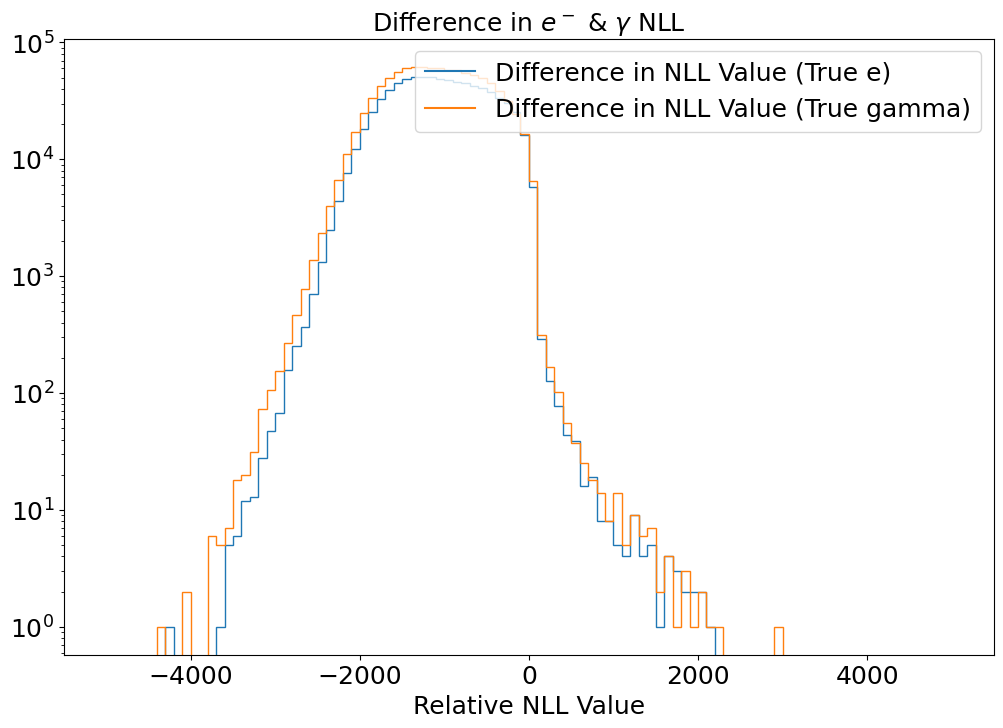

In [24]:
# Plotting the difference in e and mu NLL value
fig, ax = plt.subplots(1,1,figsize=(12,8))
ax.hist(e_nll_diff_e, range=[-5000., 5000.], bins=100, label='Difference in NLL Value (True e)', histtype='step', log=True)
ax.hist(g_nll_diff_e, range=[-5000., 5000.], bins=100, label='Difference in NLL Value (True gamma)', histtype='step', log=True)

# Create new legend handles but use the colors from the existing ones
handles, labels = ax.get_legend_handles_labels()
new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

plt.legend(handles=new_handles, labels=labels, fontsize=18)
plt.xlabel('Relative NLL Value', fontsize=18)
plt.xticks(fontsize=18)  # changing x-axis lable size
plt.yticks(fontsize=18)
plt.title('Difference in $e^-$ & $\gamma$ NLL', fontsize=18)
plt.show()

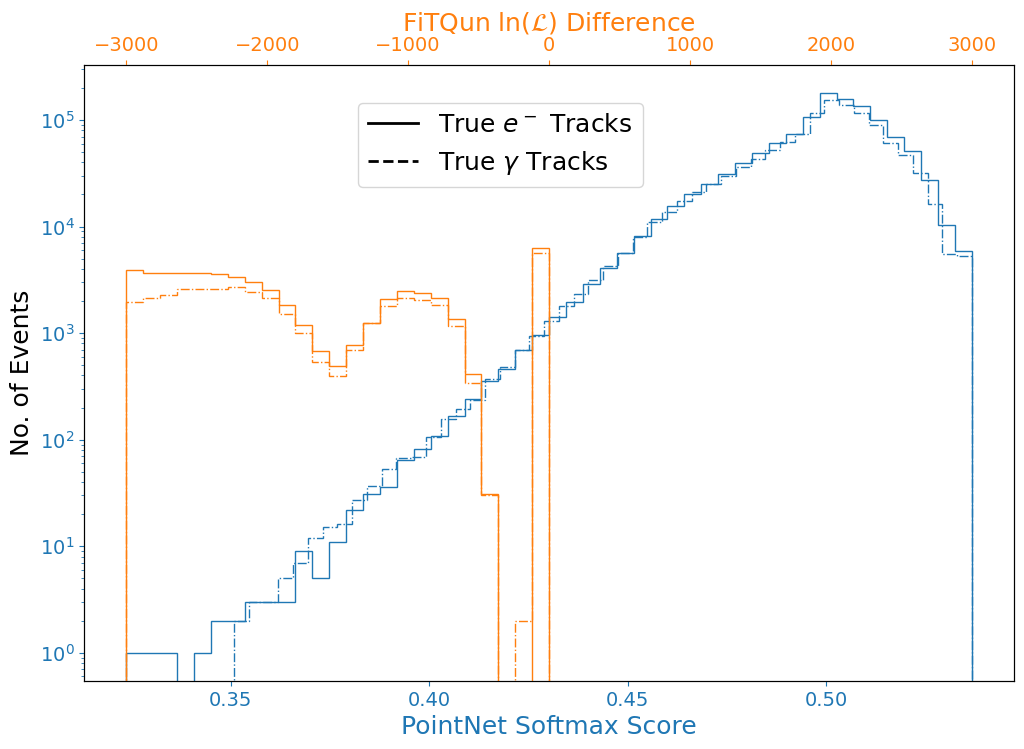

In [25]:
e_classified_as_e  = HKHybrid_softmax[HKHybrid_labels == 1][:, 1]
g_classified_as_e = HKHybrid_softmax[HKHybrid_labels == 0][:, 1]
# Create figure and axes
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twiny()

# Plotting histograms for ax1
ax1.hist(e_classified_as_e, bins=50, histtype='step', color='C0',# label='1', 
         linestyle='-', log=True)
ax1.hist(g_classified_as_e, bins=50, histtype='step', color='C0',# label='2', 
         linestyle='-.',log=True)
ax1.set_xlabel('PointNet Softmax Score', color='C0', fontsize=18)
ax1.set_ylabel('No. of Events', fontsize=18)
ax1.tick_params(which='both', colors='C0', labelsize=14)

# Plotting histograms for ax2
ax2.hist(-e_nll_diff_e, bins=50, color='C1', # label=r'ln($\mathcal{L}_e/\mathcal{L}_\mu$)(true e- track)', 
         range=[-3000,3000], histtype='step', linestyle='-', log=True)
ax2.hist(-g_nll_diff_e, bins=50, color='C1',# label=r'ln($\mathcal{L}_e/\mathcal{L}_\mu$)(true mu- track)', 
         range=[-3000,3000], histtype='step', linestyle='-.', log=True)
ax2.set_xlabel('FiTQun ln($\mathcal{L}$) Difference', color='C1', fontsize=18)
ax2.tick_params(which='both', colors='C1', labelsize=14)

# Setting legends
# Creating a global legend with black lines
legend_line_solid = plt.Line2D([0], [0], color='black', linestyle='-', linewidth=2)
legend_line_dashed = plt.Line2D([0], [0], color='black', linestyle='--', linewidth=2)
plt.figlegend([legend_line_solid, legend_line_dashed], ['True $e^-$ Tracks', 'True $\gamma$ Tracks'], 
              fontsize=18, loc=(0.35,0.75))

# Display plot
plt.savefig('../pointnet/plots/e-g_classification/softmax_n_fqNll.png')

# Generating labels from FiTQun output

In [25]:
# For e-, mu- separation
# Truth label
e_labels_e = np.ones(e_nll_diff_e.shape)
e_labels_mu = np.ones(e_nll_diff_mu.shape)
mu_labels_e = np.ones(mu_nll_diff_e.shape)*2
mu_labels_mu = np.ones(mu_nll_diff_mu.shape)*2


# concatenate labels and differences from mu and e events
diff_e = np.concatenate((mu_nll_diff_e, e_nll_diff_e), axis=0).astype(int)
labels_e = np.concatenate((mu_labels_e, e_labels_e), axis=0).astype(int)
diff_mu = np.concatenate((mu_nll_diff_mu, e_nll_diff_mu), axis=0).astype(int)
labels_mu = np.concatenate((mu_labels_mu, e_labels_mu), axis=0).astype(int)

In [26]:
# For e-, pi0 separation
# Truth label for pi0
pi0_labeled_e = np.ones(pi0_pi0nll.shape)*3

# concatenate labels
diff_e_pi0 = np.concatenate((pi0_as_e_from_pi0nll, e_as_e_from_pi0nll), axis=0).astype(int)
labels_e_pi0 = np.concatenate((pi0_labeled_e, e_labels_e), axis=0).astype(int)

In [27]:
# For e-, gamma separation
# Truth label for gamma
g_labeled_e = np.zeros(g_nll_diff_e.shape)

# concatenate labels
diff_e_g = np.concatenate((g_nll_diff_e, e_nll_diff_e), axis=0).astype(int)
labels_e_g = np.concatenate((g_labeled_e, e_labels_e), axis=0).astype(int)

# Calculating FPR and TPR

In [28]:
# for e/mu separation
fq_fpr_e, fq_tpr_e, fq_threshold_e = roc_curve(labels_e, diff_e, pos_label=2)  # Note this asks for POSIIVE 
                                                                               # label. In the above NLL plot, pos
                                                                               # for true e situation is mu 
                                                                               # (which is 2)
fq_fpr_mu, fq_tpr_mu, fq_threshold_mu = roc_curve(labels_mu, diff_mu, pos_label=1)  # Similar as above

# for e/pi0 separation
fq_fpr_e_for_pi0, fq_tpr_e_for_pi0, fq_threshold_e_for_pi0 = roc_curve(labels_e_pi0, diff_e_pi0, pos_label=3)

# for e/gamma separation
fq_fpr_e_for_g, fq_tpr_e_for_g, fq_threshold_e_for_g = roc_curve(labels_e_g, diff_e_g, pos_label=1)

In [29]:
# Calculate AUC as a check
true_e_auc = auc(fq_fpr_e, fq_tpr_e)
true_mu_auc = auc(fq_fpr_mu, fq_tpr_mu)
true_e_pi0_auc = auc(fq_fpr_e_for_pi0, fq_tpr_e_for_pi0)
true_e_g_auc = auc(fq_fpr_e_for_g, fq_tpr_e_for_g)

In [60]:
print(true_e_auc, true_mu_auc, true_e_pi0_auc, true_e_g_auc)

0.9994549837805822 0.9994549837805822 0.945834791845795 0.5164297451353652


# FiTQun reconstructed momentum

In [30]:
e_mom  = np.array(e_data.arrays('fq1rmom')['fq1rmom'][:, 0, 1])
mu_mom = np.array(mu_data.arrays('fq1rmom')['fq1rmom'][:, 0, 2])
fq_mom = np.concatenate((e_mom, mu_mom))
print(fq_mom)

[774.34344   28.711329 951.54315  ... 758.1509   445.3333   378.05807 ]


# FiTQun reconstructed momentum derived total energy

In [31]:
E_e       = np.sqrt(e_mom**2 + 0.510**2)  # m_e in MeV
E_mu      = np.sqrt(mu_mom**2 + 105**2)
fq_energies = np.concatenate((E_e, E_mu))

# Storing FiTQun NLL Scores and labels for plotting performance distribution

In [32]:
fq_likelihoods = np.concatenate((np.array(e_nll_diff_e), np.array(mu_nll_diff_e)))

fq_scores = np.zeros((fq_likelihoods.shape[0], 3))
print(fq_likelihoods.shape, fq_scores.shape)
fq_scores[:, 1] = fq_likelihoods
print(fq_scores)

fq_labels = np.concatenate((e_labels_e, mu_labels_e))
print(fq_labels, len(fq_labels))

(1619620,) (1619620, 3)
[[    0.         -2403.046875       0.        ]
 [    0.         -1923.03125        0.        ]
 [    0.         -1292.8359375      0.        ]
 ...
 [    0.           692.88476562     0.        ]
 [    0.           317.48144531     0.        ]
 [    0.           319.26074219     0.        ]]
[1. 1. 1. ... 2. 2. 2.] 1619620


# Saving to npz file

In [35]:
np.savez('processed_fq_output_ROC_w_mPMT_2mFVcut_emupi0g.npz', 
         fq_fpr_e = fq_fpr_e, fq_tpr_e = fq_tpr_e, fq_threshold_e = fq_threshold_e, 
         fq_fpr_e_for_pi0 = fq_fpr_e_for_pi0, fq_tpr_e_for_pi0 = fq_tpr_e_for_pi0, 
         fq_threshold_e_for_pi0 = fq_threshold_e_for_pi0, 
         fq_fpr_e_for_g = fq_fpr_e_for_g, fq_tpr_e_for_g = fq_tpr_e_for_g, 
         fq_threshold_e_for_g = fq_threshold_e_for_g, 
         fq_mom = fq_mom, fq_energies = fq_energies, fq_scores=fq_scores, fq_labels=fq_labels)